In [1]:
#Import Mods
import pandas as pd
import numpy as np

import glob

import matplotlib.pyplot as plt

import act
import metpy.calc as mpcalc
from metpy.units import units

from datetime import datetime
from datetime import timedelta

In [2]:
#Data grab section for KLOT ASOS
#Grab ASOS data from nearest station.
time_window = [datetime(2021, 4, 16, 0, 0), datetime(2021, 4, 24, 3, 0)]
my_asoses = act.discovery.get_asos(time_window, station = 'LOT')
station = my_asoses['LOT']

#Save off data that be used later
tempsf = station.tmpf.values
dewpsf = station.dwpf.values
time = station.time.values

Downloading: LOT


In [3]:
#Data grab section and mask creation for tree area
file = pd.read_csv("/lcrc/project/waggle/public_html/private/training_data/waggle_area510/mobotix/"
                "thermal/1618803166_000001_right_336x252_14bit.thermal.celsius.csv")

#Create image list by unpacking data from CSV and placing in correct spot.
image_array = []

for i in range(file.size):
    if i >= 6:
        data = file.values[i][0]
        data = data.split(';')
        array = np.array(data)
        array = array.astype(np.float)
        image_array.append(array)
        
        
#Create mask list with threshold value.
Tree_Mask = []
count = 0

for j in image_array:
    mask_row = []
    
    for k in range(len(j)):
        
        if k > 40 and k < 110:
        
            if count > 40 and count < 90:
                if j[k] > 7:
                    mask_row.append(1)
                else:
                    mask_row.append(0)

            else:
                 mask_row.append(0)
        else:
             mask_row.append(0)
                
    Tree_Mask.append(mask_row)
    count = count + 1
    
#create mask array and a find x-y values of for desired area
tree_array = np.array(Tree_Mask)
xt, yt = np.nonzero(tree_array)

In [4]:
#Data grab section and mask creation for mulch area.
file = pd.read_csv("/lcrc/project/waggle/public_html/private/training_data/waggle_area510/mobotix/"
                "thermal/1618776148_000001_right_336x252_14bit.thermal.celsius.csv")

#Create image list by unpacking data from CSV and placing in correct spot.
image_array = []

for i in range(file.size):
    if i >= 6:
        data = file.values[i][0]
        data = data.split(';')
        array = np.array(data)
        array = array.astype(np.float)
        image_array.append(array)
        
        
#Create mask list with threshold value.
mulch_mask = []

for j in image_array:
    mask_row = []
    for k in range(len(j)):
        
        if k > 160 and k < 210:
            
            if j[k] > 19.75:
                mask_row.append(1)
            else:
                mask_row.append(0)
                
        else:
            mask_row.append(0)

    mulch_mask.append(mask_row)
    
#create mask array and a find x-y values of for desired area
mulch_array = np.array(mulch_mask)
xm, ym = np.nonzero(mulch_array)

In [5]:
#Grab mask for ground area
file = pd.read_csv("/gpfs/fs1/home/ac.jcorner/Thermal/Masks/Ground_Area1_Mask.csv")

ground_array = np.array(file)
xg, yg = np.nonzero(ground_array)

In [6]:
#Grab files from directory and sort them into correct order
files = []
for filename in glob.glob("/lcrc/project/waggle/public_html/private/training_data/waggle_area510/mobotix/thermal/"
                          "*.thermal.celsius.csv"):
    files.append(filename)
files.sort()

In [7]:
#Run through all images and save off average temperature for each
temp_mulch = []
temp_ground = []
temp_tree = []
image_time = []


for path in files:
    file = pd.read_csv(path)
    image_time.append(datetime.fromtimestamp(int(path[86:96])) + timedelta(hours = 5))
    image_array = []
    
    
    for i in range(file.size):
        if i >= 6:
            data = file.values[i][0]
            data = data.split(';')
            array = np.array(data)
            array = array.astype(np.float)
            image_array.append(array)
            
    image_array = np.array(image_array)
    
    temp_mulch.append(np.mean(image_array[xm, ym]))
    temp_ground.append(np.mean(image_array[xg, yg]))
    temp_tree.append(np.mean(image_array[xt, yt]))

In [8]:
#assign appropiate units to values and then convert to fahrenhiet
temp_mulchc = temp_mulch * units.celsius
temp_groundc = temp_ground * units.celsius
temp_treec = temp_tree * units.celsius

temp_mulchf = temp_mulchc.to(units.fahrenheit)
temp_groundf = temp_groundc.to(units.fahrenheit)
temp_treef = temp_treec.to(units.fahrenheit)

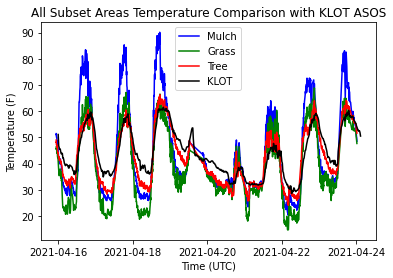

In [9]:
#Plot time series
plt.plot(image_time, temp_mulchf, color = 'blue')
plt.plot(image_time, temp_groundf, color = 'green')
plt.plot(image_time, temp_treef, color = 'red')
plt.plot(time, tempsf, color='black')

plt.xlabel('Time (UTC)')
plt.xticks(time[np.arange(0, len(time), 144)])
plt.ylabel('Temperature (F)')

plt.title('All Subset Areas Temperature Comparison with KLOT ASOS')

# Create a custom legend
plt.legend(['Mulch','Grass','Tree', 'KLOT'], loc = 'best')


#plt.savefig('Thermal_ASOS_Comparison_tree.png', transparent='true')